In [112]:
from qiskit import *
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute
import numpy as np

In [2]:
matplotlib inline

In [3]:
simulator = Aer.get_backend('qasm_simulator')

In [124]:
# Calculating S from an array of the propabitioties
def S(prob):
    s = 0
    for i in range(4):
        if i == 1:
            s -= prob[i][0] + prob[i][1] - prob[i][2] - prob[i][3]
        else:
            s += prob[i][0] + prob[i][1] - prob[i][2] - prob[i][3]
    return s

In [114]:
# preparing the rotation angles and choosing the bell state
# i = 0 for the |00> + |11>, 1 for |00> - |11>, 2 for |01> + |10>, and 3 for |01> - |10> bell states.
i = 0

# j = 0 for (a,b), j = 1 for (a, b'), j = 2 for (a', b), j = 3 for (a', b')
a = [-np.pi/4, -np.pi/4, np.pi/4, np.pi/4]
b = [0, np.pi/2, 0, np.pi/2]

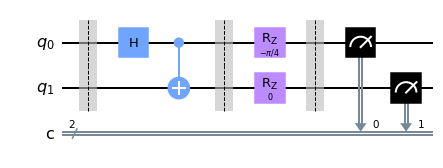

In [132]:
# CHSH
circuit = QuantumCircuit(2, 2)

# Defining the bell state
if i == 1 or i == 3: circuit.x(0)
if i >= 2: circuit.x(1)
circuit.barrier()
circuit.h(0)
circuit.cx(0, 1)
circuit.barrier()

# Defining the rotation before the measurent
j = 0
circuit.rz(a[j], 0)
circuit.rz(b[j], 1)
circuit.barrier()

# Measurement
circuit.measure(0, 0)
circuit.measure(1, 1)

circuit.draw(output='mpl')

In [116]:
result = execute(circuit, backend = simulator, shots=1000).result()
counts = result.get_counts()

print(counts)
plot_histogram(counts)

P = np.array([counts.get('00', 0), counts.get('11', 0), counts.get('10', 0), counts.get('01', 0)])
P = P/np.sum(P)
print(P)

{'00': 487, '11': 513}
[0.487 0.513 0.    0.   ]


In [136]:
# Doing the simulation for each pair of angles and recording the results, calculating S
P = np.zeros([4,4])
for j in range(4):
    circuit = QuantumCircuit(2, 2)

    # Defining the bell state
    if i == 1 or i == 3: circuit.x(0)
    if i >= 2: circuit.x(1)
    circuit.barrier()
    circuit.h(0)
    circuit.cx(0, 1)
    circuit.barrier()

    # Defining the rotation before the measurent
    circuit.rz(a[j], 0)
    circuit.rz(b[j], 1)
    circuit.barrier()

    # Measurement
    circuit.measure(0, 0)
    circuit.measure(1, 1)
    circuit.barrier()
    result = execute(circuit, backend = simulator, shots=1000).result()
    counts = result.get_counts()

    prob = np.array([counts.get('00', 0), counts.get('11', 0), counts.get('10', 0), counts.get('01', 0)])
    P[j] = prob/np.sum(prob)
print(P)
print('S is ' + str(S(P)))

[[0.528 0.472 0.    0.   ]
 [0.522 0.478 0.    0.   ]
 [0.499 0.501 0.    0.   ]
 [0.486 0.514 0.    0.   ]]
S is 2.0


In [120]:
# Load my saved IBMQ account
# IBMQ.load_account()

In [127]:
# Doing the measurement for each pair of angles and recording the results, calculating S
P = np.zeros([4,4])
for j in range(4):
    circuit = QuantumCircuit(2, 2)

    # Defining the bell state
    if i == 1 or i == 3: circuit.x(0)
    if i >= 2: circuit.x(1)
    circuit.barrier()
    circuit.h(0)
    circuit.cx(0, 1)
    circuit.barrier()

    # Defining the rotation before the measurent
    circuit.rz(a[j], 0)
    circuit.rz(b[j], 1)
    circuit.barrier()

    # Measurement
    circuit.measure(0, 0)
    circuit.measure(1, 1)
    
    # Get the least busy backend device with more than or equal to 2 qubits
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 and 
                                       not x.configuration().simulator and x.status().operational==True))
    print("least busy backend: ", backend)

    # Execute and monitor the job
    from qiskit.tools.monitor import job_monitor
    #shots = 1024
    shots = 512
    job = execute(circuit, backend=backend, shots=shots, optimization_level=3)
    job_monitor(job, interval = 2)

    # Get results
    counts = job.result().get_counts()

    prob = np.array([counts.get('00', 0), counts.get('11', 0), counts.get('10', 0), counts.get('01', 0)])
    P[j] = prob/np.sum(prob)
print(P)
print('S is ' + str(S(P)))

least busy backend:  ibmq_ourense
Job Status: job has successfully run
least busy backend:  ibmq_ourense
Job Status: job has successfully run
least busy backend:  ibmqx2
Job Status: job has successfully run
least busy backend:  ibmqx2
Job Status: job has successfully run
[[0.453125   0.48828125 0.02929688 0.02929688]
 [0.47070312 0.45898438 0.02929688 0.04101562]
 [0.43359375 0.47070312 0.06640625 0.02929688]
 [0.4296875  0.4921875  0.05664062 0.02148438]]
S is 1.67578125
